## Introduction

It has pretty much always been assumed by a lot of people, including myself, that rendering engines are colourspaces agnostic, and whatever your primaries are, it should not make any differences.

An interesting thread with some VFX industry veterans about the [Academy Color Encoding System](http://www.oscars.org/science-technology/council/projects/aces.html) has been ignited by Steve Agland.

He was describing issues while rendering in ACES RGB colourspace where the rendering equation could generate some very saturated colours, colour clipping and loss of details. Since we have started this notebook, Steve has written a post illustrating those issues, I suggest that you take a look at his [notebook](http://nbviewer.ipython.org/gist/sagland/3c791e79353673fd24fa). 

As we were discussing, [Zap 'Master' Anderson](http://mentalraytips.blogspot.fr/) pointed that he was assuming primaries wouldn't matter but that it was wrong.

The [TL;DR; version](https://groups.google.com/d/msg/academyaces/9b4VuqPcOHQ/Hg8c9V6flOYJ) of *Rick Sayre* from [Pixar](http://www.pixar.com/)

> The RGB basis vectors typically become non-orthogonal when transformed to XYZ, and definitely so in this case. 
Thus there should be no surprise that component-wise multiply does not yield a proper transform between two non-orthogonal spaces.

<!-- TEASER_END -->

## Colourspaces Agnosticism

We will demonstrate the issue in the following section, notice that it doesn't actually just only concern rendering but compositing, etc... Elle Stone has for example written an article about that problem in the context of image editing in [unbound *sRGB* colourspace](http://ninedegreesbelow.com/photography/unbounded-srgb-as-universal-working-space.html).

We choose some references colours in *CIE XYZ* colourspace (*dark skin* and *green*) from *ColorChecker 2005*. A unique colour is enough to showcase the issue but we will use two in order to be closer of the rendering context where multiple colours interact together. We can for instance assume that *dark skin* is a texture and *green* a light.

We convert them to *sRGB* and *Adobe RGB 1998* colourspaces. We have chosen those 2 colourspaces because they have the same whitepoint and thus discount chromatic adaptation, essentially removing a problem from the equation so that it is easier to understand:

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pylab

import colour
from colour.utilities.verbose import message_box

name, data, illuminant = colour.COLOURCHECKERS['ColorChecker 2005']

sRGB_w = colour.sRGB_COLOURSPACE.whitepoint
sRGB_XYZ_to_RGB = colour.sRGB_COLOURSPACE.XYZ_to_RGB_matrix
sRGB_RGB_to_XYZ = colour.sRGB_COLOURSPACE.RGB_to_XYZ_matrix
adobe98_w = colour.ADOBE_RGB_1998_COLOURSPACE.whitepoint
adobe98_XYZ_to_RGB = colour.ADOBE_RGB_1998_COLOURSPACE.XYZ_to_RGB_matrix
adobe98_RGB_to_XYZ = colour.ADOBE_RGB_1998_COLOURSPACE.RGB_to_XYZ_matrix

# Preparing *dark skin* colour in various colourspaces.
index, name, x, y, Y = data[0]
XYZ_r1 = colour.xyY_to_XYZ((x, y, Y))

# *sRGB* colourspace 0-255 values with OETF applied.
sRGB_rd1 = colour.XYZ_to_sRGB(XYZ_r1, illuminant)

# *sRGB* colourspace linear values.
sRGB_r1 = colour.XYZ_to_RGB(XYZ_r1,
                            illuminant,
                            sRGB_w,
                            sRGB_XYZ_to_RGB)

# *Adobe RGB 1998* colourspace linear values.
adobe98_r1 = colour.XYZ_to_RGB(XYZ_r1,
                               illuminant,
                               adobe98_w,
                               adobe98_XYZ_to_RGB)

message_box(('Reference "dark skin" "CIE XYZ" colourspace tristimulus '
             'values:\n'
             '\t{0}\n'
             '\n"sRGB" colourspace values (OETF):\n'
             '\n\t{1}\n'
             '\n"sRGB" and "Adobe RGB 1998" colourspaces (Linear):\n'
             '\tsRGB: {2}\n\tAdobe RGB 1998: {3}').format(
    XYZ_r1,
    np.around(sRGB_rd1 * 255),
    sRGB_r1,
    adobe98_r1))

# Preparing *green* colour in various colourspaces.
index, name, x, y, Y = data[13]
XYZ_r2 = colour.xyY_to_XYZ((x, y, Y))

# *sRGB* colourspace 0-255 values with OETF applied.
sRGB_rd2 = colour.XYZ_to_sRGB(XYZ_r2, illuminant)

# *sRGB* colourspace linear values.
sRGB_r2 = colour.XYZ_to_RGB(XYZ_r2,
                            illuminant,
                            sRGB_w,
                            sRGB_XYZ_to_RGB)

# *Adobe RGB 1998* colourspace linear values.
adobe98_r2 = colour.XYZ_to_RGB(XYZ_r2,
                               illuminant,
                               adobe98_w,
                               adobe98_XYZ_to_RGB)

message_box(('Reference "green" "CIE XYZ" colourspace tristimulus '
             'values:\n'
             '\t{0}\n'
             '\n"sRGB" colourspace values (OETF):\n'
             '\t{1}\n'
             '\n"sRGB" and "Adobe RGB 1998" colourspaces (Linear):\n'
             '\tsRGB: {2}\n\tAdobe RGB 1998: {3}').format(
    XYZ_r2,
    np.around(sRGB_rd2 * 255),
    sRGB_r2,
    adobe98_r2))

*                                                                             *
*   Reference "dark skin" "CIE XYZ" colourspace tristimulus values:           *
*           [ 0.11518475  0.1008      0.05089373]                             *
*                                                                             *
*   "sRGB" colourspace values (OETF):                                         *
*                                                                             *
*           [ 115.   81.   68.]                                               *
*                                                                             *
*   "sRGB" and "Adobe RGB 1998" colourspaces (Linear):                        *
*           sRGB: [ 0.172906    0.08205715  0.05711951]                       *
*           Adobe RGB 1998: [ 0.14702493  0.08205715  0.05814617]             *
*                                                                             *
*                                       

True

Everything is setup and we are ready to apply some transformations but first, as a sanity check we ensure that *dark skin* properly converts back to *CIE XYZ* tristimulus values:

In [3]:
XYZ_sRGB1 = colour.RGB_to_XYZ(sRGB_r1,
                              sRGB_w,
                              illuminant,
                              sRGB_RGB_to_XYZ)

XYZ_adobe981 = colour.RGB_to_XYZ(adobe98_r1,
                                 adobe98_w,
                                 illuminant,
                                 adobe98_RGB_to_XYZ)

message_box(('Converting back "dark skin" "CIE XYZ" colourspace '
             'tristimulus values from "sRGB" and "Adobe RGB 1998" '
             'colourspaces:\n'
             '\tFrom sRGB: {0}\n\tFrom Adobe RGB 1998: {1}\n'
             '\nEverything looks fine!').format(
    XYZ_sRGB1, XYZ_adobe981))

*                                                                             *
*   Converting back "dark skin" "CIE XYZ" colourspace tristimulus values      *
*   from "sRGB" and "Adobe RGB 1998" colourspaces:                            *
*           From sRGB: [ 0.11518475  0.1008      0.05089373]                  *
*           From Adobe RGB 1998: [ 0.11518475  0.1008      0.05089373]        *
*                                                                             *
*   Everything looks fine!                                                    *
*                                                                             *


True

We multiply *dark skin* colour by *green* $n$ times and scale the result to obtain displayable values:

$$
\begin{equation}
\begin{aligned}
sRGB_m&= sRGB_{r1}\cdot sRGB_{r2}\cdot sRGB_{r2}\cdot sRGB_{r2}\cdot sRGB_k\\
adobe98_m&= adobe98_{r1}\cdot adobe98_{r2}\cdot adobe98_{r2}\cdot adobe98_{r2}\cdot adobe98_k
\end{aligned}
\end{equation}
$$

Where

$$
\begin{equation}
\begin{aligned}
sRGB_{r1}&=\ 'dark\ skin'\\
sRGB_{r2}&=\ 'green'\\
adobe98_{r1}&=\ 'dark\ skin'\\
adobe98_{r2}&=\ 'green'
\end{aligned}
\end{equation}
$$

With $sRGB_k$ and $adobe98_k$ being equivalent arbitrary scaling factors for each colourspace.

We then convert everything back to *CIE XYZ* colourspace:

In [4]:
k = np.array([500, 500, 500])

sRGB_k = colour.XYZ_to_RGB(k,
                           illuminant,
                           sRGB_w,
                           sRGB_XYZ_to_RGB)
adobe98_k = colour.XYZ_to_RGB(k,
                              illuminant,
                              adobe98_w,
                              adobe98_XYZ_to_RGB)

sRGB_m = sRGB_r1 * sRGB_r2 * sRGB_r2 * sRGB_r2 * sRGB_k
adobe98_m = adobe98_r1 * adobe98_r2 * adobe98_r2 * adobe98_r2 * adobe98_k

XYZ_sRGB_m1 = colour.RGB_to_XYZ(sRGB_m,
                                sRGB_w,
                                sRGB_w,
                                sRGB_RGB_to_XYZ)

XYZ_adobe98_m1 = colour.RGB_to_XYZ(adobe98_m,
                                   adobe98_w,
                                   adobe98_w,
                                   adobe98_RGB_to_XYZ)

message_box(('Multiplying "dark skin" with "green" and converting back to '
             '"CIE XYZ" colourspace tristimulus values from "sRGB" and '
             '"Adobe RGB 1998" colourspaces:\n'
             '\tFrom sRGB: {0}\n\tFrom Adobe RGB 1998: {1}\n'
             '\nHouston? We have a problem!').format(
    XYZ_sRGB_m1, XYZ_adobe98_m1))

*                                                                             *
*   Multiplying "dark skin" with "green" and converting back to "CIE XYZ"     *
*   colourspace tristimulus values from "sRGB" and "Adobe RGB 1998"           *
*   colourspaces:                                                             *
*           From sRGB: [ 0.38869578  0.76482524  0.13960073]                  *
*           From Adobe RGB 1998: [ 0.28287392  0.71107141  0.0980476 ]        *
*                                                                             *
*   Houston? We have a problem!                                               *
*                                                                             *


True

The *CIE XYZ* colourspace tristimulus values are not equal!

The consequence of this is that if two renders are done while using the same dataset in two different colourspaces, they will not yield the same image.

In order to visualise the discrepancy, the difference between the two *dark_skin* colours lit by the *green* light is plotted:

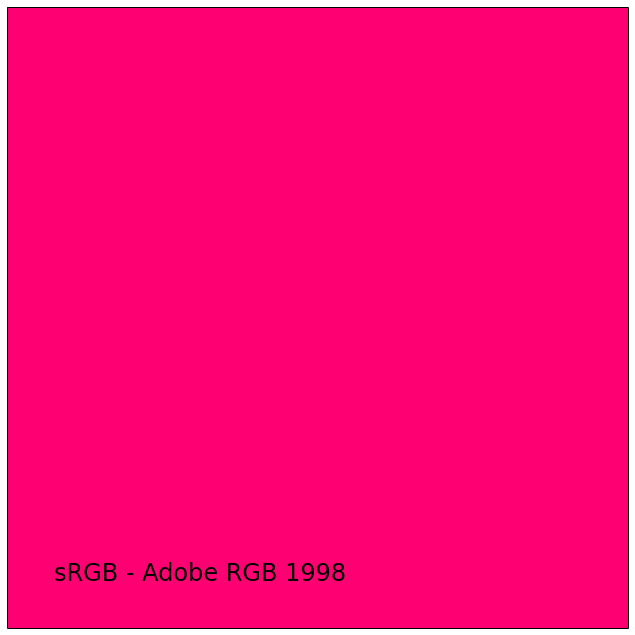

True

In [5]:
from colour.plotting import *

sRGB_m1 = colour.XYZ_to_sRGB(XYZ_sRGB_m1)
adobe98_m1 = colour.XYZ_to_sRGB(XYZ_adobe98_m1)

sRGB_difference = sRGB_m1 - adobe98_m1

# The difference is producing negative values thus we clip the result, although the
# remaining data should illustrate the effect.
sRGB_difference = np.clip(sRGB_difference, 0, 1)

single_colour_plot(colour_parameter('sRGB - Adobe RGB 1998', sRGB_difference), text_size=24)

The chromaticity coordinates are also out of the boundaries of their respective colourspaces:

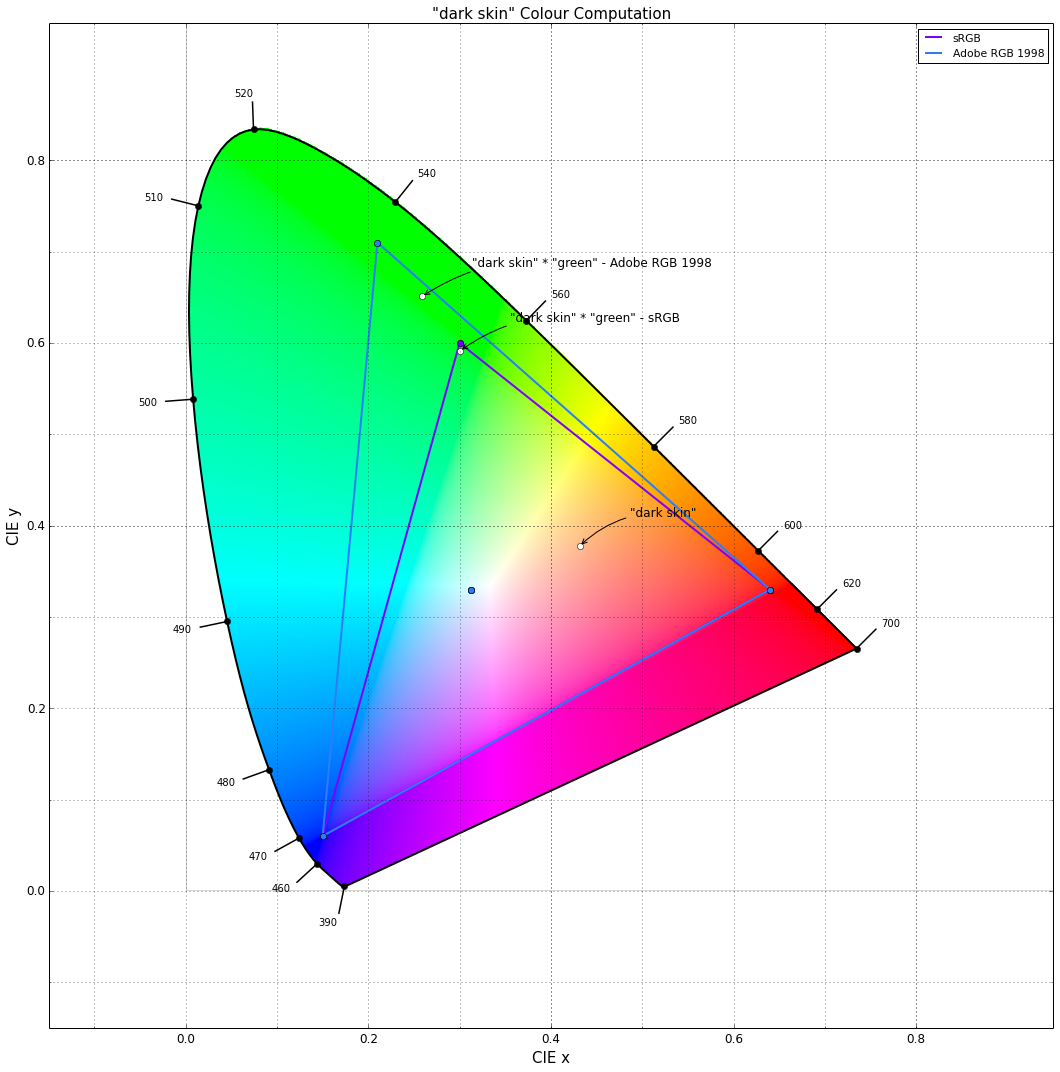

True

In [6]:
colourspaces_CIE_1931_chromaticity_diagram_plot(
    ['sRGB', 'Adobe RGB 1998'],
standalone=False,
title='"dark skin" Colour Computation')

for name, XYZ in (('"dark skin"', XYZ_r1),
                  ('"dark skin" * "green" - sRGB', XYZ_sRGB_m1),
                  ('"dark skin" * "green" - Adobe RGB 1998', XYZ_adobe98_m1)):
    
    xy = colour.XYZ_to_xy(XYZ)

    pylab.plot(xy[0], xy[1], 'o', color='white')
    pylab.annotate(name,
                   xy=xy,
                   xytext=(50, 30),
                   textcoords='offset points',
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=0.2'))

display(standalone=True)

Finally, we mathematically quantify the difference by calculating the colour difference $\Delta_{E_{ab}}$:

In [7]:
Lab1 = colour.XYZ_to_Lab(XYZ_sRGB_m1, illuminant)
Lab2 = colour.XYZ_to_Lab(XYZ_adobe98_m1, illuminant)

print(colour.delta_E_CIE2000(Lab1, Lab2))

4.90614603088


This more than two times the just noticable threshold ($JND=2.3$).

## With ACES RGB...

We will do the same computations but this time comparing *sRGB* colourspace with *ACES RGB* colourspace using the whole colour rendition chart:

In [8]:
from pprint import pprint

aces_w = colour.ACES_RGB_COLOURSPACE.whitepoint
aces_XYZ_to_RGB = colour.ACES_RGB_COLOURSPACE.XYZ_to_RGB_matrix
aces_RGB_to_XYZ = colour.ACES_RGB_COLOURSPACE.RGB_to_XYZ_matrix

aces_r2 = colour.XYZ_to_RGB(XYZ_r2,
                            illuminant,
                            aces_w,
                            aces_XYZ_to_RGB)
aces_k = colour.XYZ_to_RGB(k,
                           illuminant,
                           aces_w,
                           aces_XYZ_to_RGB)

XYZs_m = []
for index, name, x, y, Y in data:
    xyY = np.array([x, y, Y])
    sRGB_r1 = colour.XYZ_to_RGB(
        colour.xyY_to_XYZ(xyY),
        illuminant,
        sRGB_w,
        sRGB_XYZ_to_RGB)
    sRGB_m = sRGB_r1 * sRGB_r2 * sRGB_r2 * sRGB_r2 * sRGB_k

    aces_r1 = colour.XYZ_to_RGB(
        colour.xyY_to_XYZ(xyY),
        illuminant,
        aces_w,
        aces_XYZ_to_RGB)
    aces_m = aces_r1 * aces_r2 * aces_r2 * aces_r2 * aces_k
    
    XYZ_sRGB_m1 = colour.RGB_to_XYZ(sRGB_m,
                                    sRGB_w,
                                    sRGB_w,
                                    sRGB_RGB_to_XYZ)
    XYZ_aces_m1 = colour.RGB_to_XYZ(aces_m,
                                    aces_w,
                                    aces_w,
                                    aces_RGB_to_XYZ)
    XYZs_m.append((XYZ_sRGB_m1, XYZ_aces_m1))

pprint(XYZs_m)

[(array([ 0.38869578,  0.76482524,  0.13960073]),
  array([ 0.20268126,  0.60365236,  0.03364468])),
 (array([ 1.38456752,  2.72573459,  0.50101318]),
  array([ 0.69072112,  2.12275751,  0.12698879])),
 (array([ 0.92852793,  1.82982909,  0.37612784]),
  array([ 0.30939555,  1.31947147,  0.16922992])),
 (array([ 0.69359492,  1.3785311 ,  0.24114326]),
  array([ 0.19083716,  0.88582441,  0.0350462 ])),
 (array([ 1.03144188,  2.02284727,  0.43022108]),
  array([ 0.44387339,  1.58908042,  0.22006831])),
 (array([ 2.40152185,  4.77004663,  0.88445106]),
  array([ 0.54698139,  3.01866894,  0.22818611])),
 (array([ 0.95490787,  1.86993573,  0.31732109]),
  array([ 0.70738428,  1.66657639,  0.03354826])),
 (array([ 0.51278009,  0.99598882,  0.25222686]),
  array([ 0.23696274,  0.86242913,  0.19645941])),
 (array([ 0.41771695,  0.79872923,  0.15820317]),
  array([ 0.52233613,  0.98114033,  0.06715399])),
 (array([ 0.20837929,  0.40166426,  0.09743945]),
  array([ 0.1561374 ,  0.40618319,  0.070

We can then compute the colour difference $\Delta_{E_{ab}}$ for each sample:

In [9]:
deltas_E = []
for i, (XYZ1, XYZ2) in enumerate(XYZs_m):
    Lab1 = colour.XYZ_to_Lab(XYZ1, illuminant)
    Lab2 = colour.XYZ_to_Lab(XYZ2, illuminant)
    deltas_E.append((data[i][1], colour.delta_E_CIE2000(Lab1, Lab2)))

pprint(deltas_E)

[(u'dark skin', 8.3613623420756102),
 (u'light skin', 8.9556903598189113),
 (u'blue sky', 13.432983122505807),
 (u'foliage', 14.044848895924677),
 (u'blue flower', 11.093053002998042),
 (u'bluish green', 16.406382114232013),
 (u'orange', 9.6603921006793581),
 (u'purplish blue', 11.67133903883059),
 (u'moderate red', 10.023064455433264),
 (u'purple', 5.9334057826699187),
 (u'yellow green', 14.805099712548397),
 (u'orange yellow', 10.551947850196745),
 (u'blue', 11.278210364179239),
 (u'green', 17.082603183950241),
 (u'red', 21.33752766059369),
 (u'yellow', 12.190174742826901),
 (u'magenta', 8.2445114939752369),
 (u'cyan', 17.17140261974528),
 (u'white 9.5 (.05 D)', 12.371645422300608),
 (u'neutral 8 (.23 D)', 12.322635558756119),
 (u'neutral 6.5 (.44 D)', 12.222855188415945),
 (u'neutral 5 (.70 D)', 11.938433138820654),
 (u'neutral 3.5 (1.05 D)', 11.766891985163152),
 (u'black 2 (1.5 D)', 11.295535127310735)]


As you can see, depending the samples colour difference $\Delta_{E_{ab}}$ can reach dramatic values. The average colour difference on the whole colour rendition chart is as follows:

In [10]:
np.average([delta_E[1] for delta_E in deltas_E])

12.256749802664634

## With Rec. 2020...

Again, the same computations but this time comparing *sRGB* colourspace with *Rec. 2020* colourspace.

In [11]:
from pprint import pprint

rec2020_w = colour.REC_2020_COLOURSPACE.whitepoint
rec2020_XYZ_to_RGB = colour.REC_2020_COLOURSPACE.XYZ_to_RGB_matrix
rec2020_RGB_to_XYZ = colour.REC_2020_COLOURSPACE.RGB_to_XYZ_matrix

rec2020_r2 = colour.XYZ_to_RGB(XYZ_r2,
                               illuminant,
                               rec2020_w,
                               rec2020_XYZ_to_RGB)
rec2020_k = colour.XYZ_to_RGB(k,
                              illuminant,
                              aces_w,
                              aces_XYZ_to_RGB)
XYZs_m = []
for index, name, x, y, Y in data:
    xyY = np.array([x, y, Y])
    sRGB_r1 = colour.XYZ_to_RGB(
        colour.xyY_to_XYZ(xyY),
        illuminant,
        sRGB_w,
        sRGB_XYZ_to_RGB)
    sRGB_m = sRGB_r1 * sRGB_r2 * sRGB_r2 * sRGB_r2 * sRGB_k

    rec2020_r1 = colour.XYZ_to_RGB(
        colour.xyY_to_XYZ(xyY),
        illuminant,
        rec2020_w,
        rec2020_XYZ_to_RGB)
    rec2020_m = rec2020_r1 * rec2020_r2 * rec2020_r2 * rec2020_r2 * rec2020_k

    XYZ_sRGB_m1 = colour.RGB_to_XYZ(sRGB_m,
                                    sRGB_w,
                                    sRGB_w,
                                    sRGB_RGB_to_XYZ)
    XYZ_rec2020_m1 = colour.RGB_to_XYZ(rec2020_m,
                                       rec2020_w,
                                       rec2020_w,
                                       rec2020_RGB_to_XYZ)
    XYZs_m.append((XYZ_sRGB_m1, XYZ_rec2020_m1))

pprint(XYZs_m)

[(array([ 0.38869578,  0.76482524,  0.13960073]),
  array([ 0.25853752,  0.70148175,  0.05716381])),
 (array([ 1.38456752,  2.72573459,  0.50101318]),
  array([ 0.89307458,  2.46736894,  0.20938258])),
 (array([ 0.92852793,  1.82982909,  0.37612784]),
  array([ 0.4476039 ,  1.47882622,  0.21349428])),
 (array([ 0.69359492,  1.3785311 ,  0.24114326]),
  array([ 0.32760172,  1.10831102,  0.07492719])),
 (array([ 1.03144188,  2.02284727,  0.43022108]),
  array([ 0.57059404,  1.71920717,  0.26897265])),
 (array([ 2.40152185,  4.77004663,  0.88445106]),
  array([ 1.00942471,  3.68779206,  0.35432283])),
 (array([ 0.95490787,  1.86993573,  0.31732109]),
  array([ 0.82224442,  1.93413951,  0.10070503])),
 (array([ 0.51278009,  0.99598882,  0.25222686]),
  array([ 0.27187771,  0.83126526,  0.21373168])),
 (array([ 0.41771695,  0.79872923,  0.15820317]),
  array([ 0.52016768,  1.01546347,  0.09730777])),
 (array([ 0.20837929,  0.40166426,  0.09743945]),
  array([ 0.16245725,  0.3957943 ,  0.080

We again compute the colour difference $\Delta_E$:

In [12]:
deltas_E = []
for i, (XYZ1, XYZ2) in enumerate(XYZs_m):
    Lab1 = colour.XYZ_to_Lab(XYZ1, illuminant)
    Lab2 = colour.XYZ_to_Lab(XYZ2, illuminant)
    deltas_E.append((data[i][1], colour.delta_E_CIE2000(Lab1, Lab2, l=1)))

pprint(deltas_E)

[(u'dark skin', 6.186862353654381),
 (u'light skin', 6.6841065817906804),
 (u'blue sky', 9.9232992371789344),
 (u'foliage', 9.3146056130510342),
 (u'blue flower', 8.5710337656737838),
 (u'bluish green', 11.091417794697131),
 (u'orange', 6.856998379754125),
 (u'purplish blue', 9.9593838336339058),
 (u'moderate red', 8.4147777495143163),
 (u'purple', 4.7878515344863057),
 (u'yellow green', 9.7069670435799722),
 (u'orange yellow', 7.1359690495715338),
 (u'blue', 10.297704619280728),
 (u'green', 10.948839961415668),
 (u'red', 17.995992699335542),
 (u'yellow', 8.0907740434874338),
 (u'magenta', 6.2573732490286149),
 (u'cyan', 12.272493214747699),
 (u'white 9.5 (.05 D)', 8.8933966206553361),
 (u'neutral 8 (.23 D)', 8.8473904596447657),
 (u'neutral 6.5 (.44 D)', 8.7498743874243026),
 (u'neutral 5 (.70 D)', 8.5177561630589675),
 (u'neutral 3.5 (1.05 D)', 8.3485958287626083),
 (u'black 2 (1.5 D)', 7.9149962914638188)]


Finally, we compute the average colour difference:

In [13]:
np.average(np.average([delta_E[1] for delta_E in deltas_E]))

8.9903525197871481

## Analytical Explanation

Converting from a colourspace $RGB_1$ to another colourspace $RGB_2$ is done by applying a series of linear transformations (matrices) as follows:

$$
\begin{equation}
\begin{vmatrix}
R_2\\
G_2\\
B_2
\end{vmatrix}=
\textbf{M}_{RGB_2}\cdot \textbf{M}_{XYZ_1}
\begin{vmatrix}
R_1\\
G_1\\
B_1
\end{vmatrix}
\end{equation}
$$

where $\textbf{M}_{RGB_2}$ is the $3x3$ matrix transforming from *CIE XYZ* colourspace to $RGB_2$ colourspace and $\textbf{M}_{XYZ_1}$ is the $3x3$ matrix transforming from $RGB_1$ colourspace to *CIE XYZ* colourspace.

> Note: We have discounted chromatic adaptation to makes things easier.

Here are such $\textbf{M}_{XYZ_1}$ matrices for respectively *sRGB* and *ACES RGB* colourspaces:

$$
\begin{equation}
\textbf{M}_{XYZ_{sRGB}}=
\begin{vmatrix}
0.41238656&0.35759149&0.18045049\\
0.21263682&0.71518298&0.0721802\\
0.01933062&0.11919716&0.95037259\\
\end{vmatrix}\\
\textbf{M}_{XYZ_{ACES}}=
\begin{vmatrix}
0.9525524&0&0.00009368\\
0.34396645&0.7281661&-0.07213255\\
0&0&1.00882518\\
\end{vmatrix}\\
\end{equation}
$$

Matrices are really just a system of multiple linear equations, thus we can express $\textbf{M}_{XYZ_{sRGB}}$ as follows:

$$
\begin{equation}
\begin{aligned}
X&=\ 0.41238656R+0.35759149G+0.18045049B\\
Y&=\ 0.21263682R+0.71518298G+0.0721802B\\
Z&=\ 0.01933062R+0.11919716G+0.95037259B\\
\end{aligned}
\end{equation}
$$

We will simplify the problem again by just considering the first equation of each system, the first row of each matrix:

$$
\begin{equation}
\begin{aligned}
X_{sRGB}&=\ 0.41238656R+0.35759149G+0.18045049B\\
X_{ACES}&=\ 0.9525524R+0.0G+0.00009368B\\
\end{aligned}
\end{equation}
$$

We plot the functions by using a uniformly spaced incrementing $k$ variable in place of $RGB$:

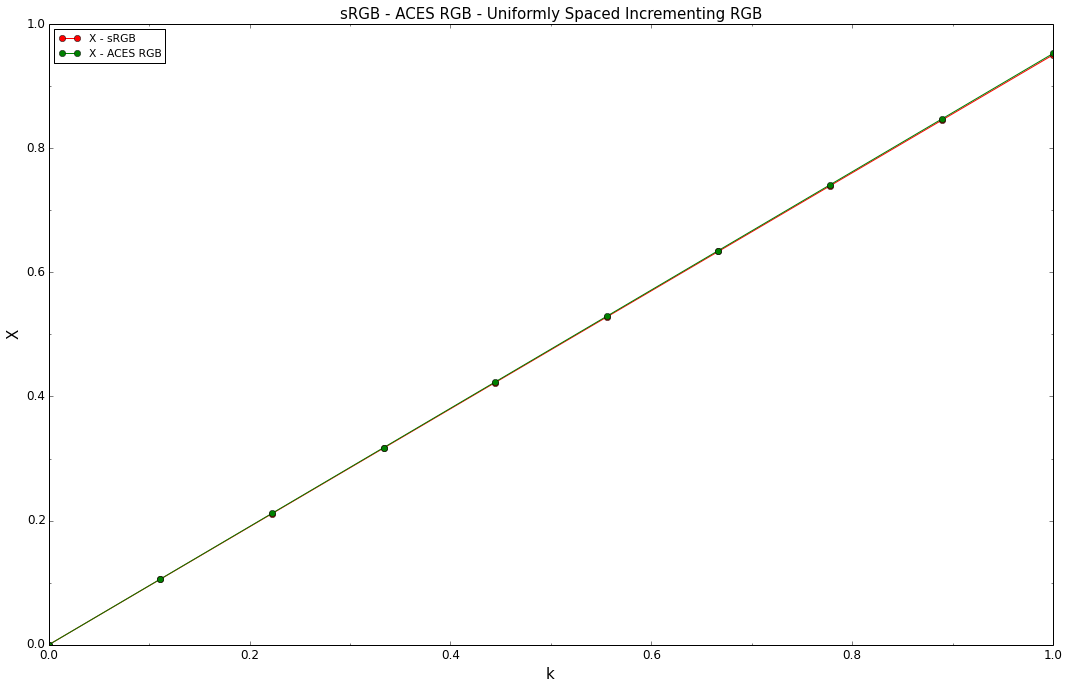

True

In [14]:
k = np.linspace(0, 1, 10)
X_sRGB = lambda x: 0.41238656 * x + 0.35759149 * x + 0.18045049 * x
X_ACES = lambda x: 0.9525524 * x + 0.00009368 * x

pylab.plot(k, tuple(map(X_sRGB, k)), 'o-', color='red', label='X - sRGB')
pylab.plot(k, tuple(map(X_ACES, k)), 'o-', color='green', label='X - ACES RGB')

settings = {'title': 'sRGB - ACES RGB - Uniformly Spaced Incrementing RGB',
            'x_label': 'k',
            'y_label': 'X',
            'x_tighten': True,
            'legend': True,
            'legend_location': 'upper left',
            'x_ticker': True,
            'y_ticker': True}
decorate(**settings)
display(**settings)

They match each other very well, which is the expected and correct behavior, now we re-plot the functions while only incrementing the $R$ component:

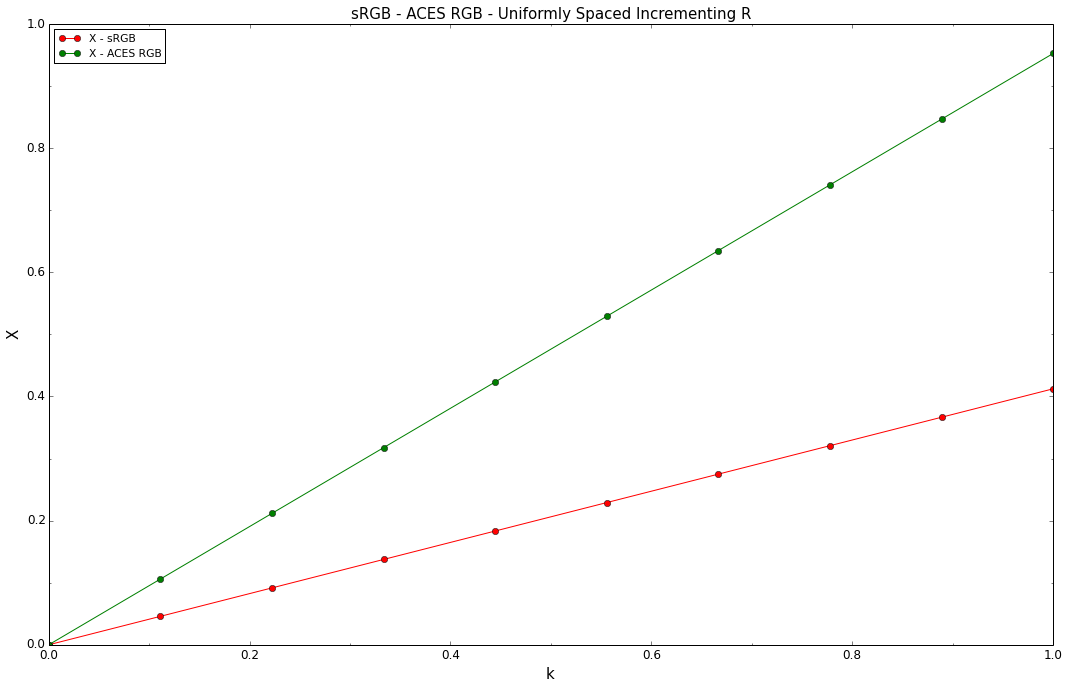

True

In [15]:
k = np.linspace(0, 1, 10)
X_sRGB = lambda x: 0.41238656 * x
X_ACES = lambda x: 0.9525524 * x

pylab.plot(k, tuple(map(X_sRGB, k)), 'o-', color='red', label='X - sRGB')
pylab.plot(k, tuple(map(X_ACES, k)), 'o-', color='green', label='X - ACES RGB')

settings = {'title': 'sRGB - ACES RGB - Uniformly Spaced Incrementing R',
            'x_label': 'k',
            'y_label': 'X',
            'x_tighten': True,
            'legend': True,
            'legend_location': 'upper left',
            'x_ticker': True,
            'y_ticker': True}
decorate(**settings)
display(**settings)

The slopes are obviously very different now, *ACES RGB* is steeper than *sRGB*. This is the result of the respective colourspaces basis vectors not being orthogonal. In this case it leads to colours approaching the spectral locus boundaries in *ACES RGB* faster than *sRGB*. It is the reason why in some instances secondary bounces quickly lead to very saturated colours.

This can be again demonstrated by multiplying our *dark skin* and *green* colours from above computations and plotting them:

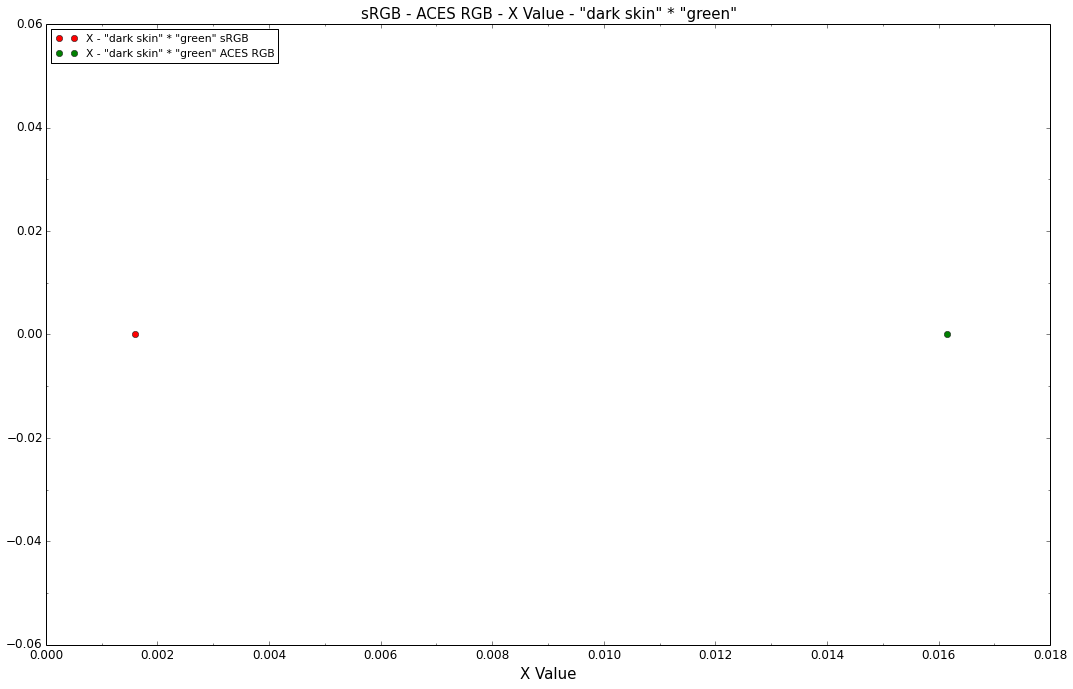

True

In [16]:
pylab.plot(X_sRGB(0.172906) * X_sRGB(0.05440562), 0, 'o', color='red', label='X - "dark skin" * "green" sRGB')
pylab.plot(X_ACES(0.11758989) * X_ACES(0.15129818), 0, 'o', color='green', label='X - "dark skin" * "green" ACES RGB')

settings = {'title': 'sRGB - ACES RGB - X Value - "dark skin" * "green"',
            'x_label': 'X Value',
            'x_tighten': True,
            'legend': True,
            'legend_location': 'upper left',
            'x_ticker': True,
            'y_ticker': True}
decorate(**settings)
display(**settings)

## Conclusion

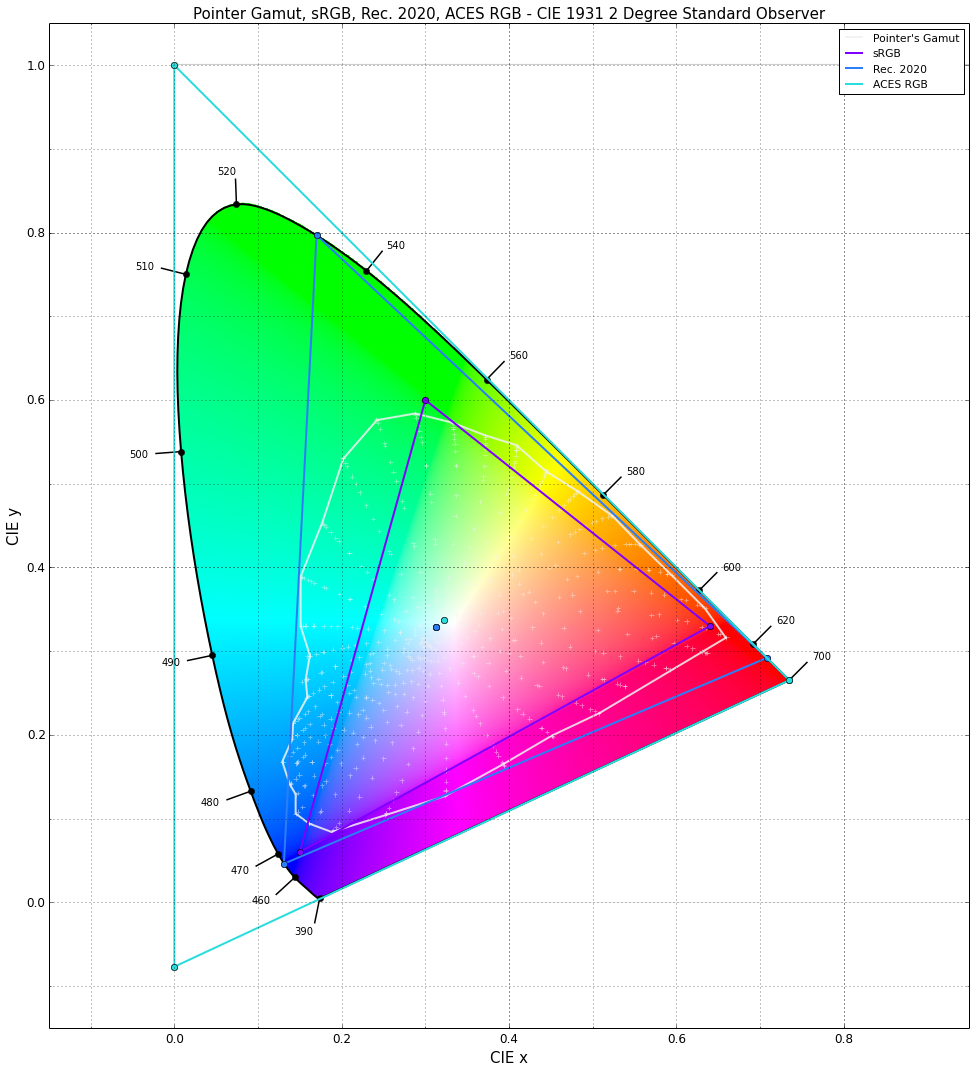

True

In [17]:
colourspaces_CIE_1931_chromaticity_diagram_plot(
    ['Pointer Gamut', 'sRGB', 'Rec. 2020', 'ACES RGB'])

While most of this is tied to basic linear algebra, it has been overlooked by most of VFX industry veterans. We were assuming wrongly that rendering engines are colourspaces agnostic.

On a strictly technical point of view, rendering engines are indeed colourspaces agnostic. They just chew through whatever data you throw at them without making any consideration of the colourspace the data is stored into.

However the choice of colourspace and its primaries is critical to achieve a faithful rendering. In rendering context, wide gamut colour spaces are prone to create colours with very high chroma and this can be a major issue when trying to achieve photo-realistic output.

The root cause of those issues is linked to the current $RGB$ lighting model that *most* rendering engines use. There are a lot of practical reasons to use the $RGB$ lighting model instead of a full spectral model, especially when our data representation is based on a $RGB$ triplet. It is indeed very hard to measure reflectance data in large volumes and with enough control and resolution for production work. Applications to manipulate that reflectance data don't exist or are tools dedicated to scientists, thus not really useful for content creation. As of today, it is impossible to launch *Spectral Photoshop* in order to apply a *Spectral Gaussian Blur* on a *Spectral Textures* dataset.

Plates and photographs are often shot with a lighting setup that doesn't match any known illuminant or worse, mixes multiple light sources with different relative spectral power distributions. HDRI images used for lighting are no exception and cannot convey properly the illumination of a scene. 

We may be often tempted to think of photographs as *true* reflectance data, but they are actually reflected spectra: They have already been multiplied by the spectra of multiple different light sources and by the reflected spectra from neighbour surfaces. They should not be assimilated to quantities meaningful in really accurate colorimetry computations.

Another issue is that artists are able to specify colours from the whole current colourspace volume without accounting for the fact that their chromaticities can be outside the boundary of any real object colour gamuts like Pointer's Gamut, ISO 12640-3 or Xun Li's Gamut, thus almost systematically yielding implausible colours. It seems a necessity to have tools allowing to check that:

* Picked colours are within the volume of a real object colours gamut (Pointer's Gamut for instance).
* At any moment, displayed colours on a device are within the volume of a real object colours gamut.
* Existing colours in a texture or a photo are within the volume of a real object colours gamut.

The $RGB$ lighting model doesn't allow precise colorimetric value computations but we still can produce images faithful and pleasing thanks to our artistic sense. We have been doing that for years and this is probably the most important thing for the entertainment industry.

Ultimately, the solution will be the switch to spectral rendering, it will happen. Question is when? There are already quite a lot of spectral renderers outside. Weta Digital has been using [Manuka](http://www.fxguide.com/featured/manuka-weta-digitals-new-renderer/) on a few movies already. We still need to address the issues with reflectance data before they become mainstream. While its theoretically impossible to reconstruct a spectral power distribution from a single $RGB$ triplet because an infinity of spectral power distributions yield to the same tristimulus values, some research has been done on the problem and a few methods exists. For example, *Brian Smits (1999)* describes a method that leads to [very good results](http://nbviewer.ipython.org/github/colour-science/colour-website/blob/master/ipython/about_reflectance_recovery.ipynb). The recovered reflectance data is not useful for precise colorimetry but it yields very good results in the context of computer graphics imagery.

As of now, we continue discussing what colourspace is the best for computations in the $RGB$ lighting model and the issue has also been raised on the [ACES mailing list](https://groups.google.com/forum/#!topic/academyaces/9b4VuqPcOHQ).

## November 28, 2014 - Erratum

Elle Stone sent me a mail with various questions regarding the document including her concerns that the chromaticities in the computations were falling outside their respective colourspaces gamut in the *"dark skin" - Colour Computation* figure.

This is indeed an issue and should never happen in the context of those computations. Given positive *RGB* values and accurate conversion to *xy* chromaticities coordinates, the latter should be located within the boundaries of the reference colourspace.

I tracked down the problem to an erroneous whitepoint adaptation: As an early sanity check, we were converting back to *CIE XYZ* tristimulus values, ensuring the API was working correctly:

In [18]:
XYZ_sRGB1 = colour.RGB_to_XYZ(sRGB_r1,
                              sRGB_w,
                              illuminant,
                              sRGB_RGB_to_XYZ)

Unfortunately the same code was also used for the tristimulus values conversion post-multiplication operation:

In [19]:
XYZ_sRGB_m1 = colour.RGB_to_XYZ(sRGB_m,
                                sRGB_w,
                                illuminant,
                                sRGB_RGB_to_XYZ)

As a result, we were chromatically adapting to *CIE Illuminant C* instead of the colourspaces *CIE Illuminant D Series D65*. 
In the current context, the correct conversion to tristimulus values should entirely bypass chromatic adaptation since the source and target whitepoints are the same.

Incorrect instances of the code have been fixed and figures updated accordingly.